In [5]:
import numpy as np
import gymnasium as gym
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
# Classe que define a política target determinística
class TargetPolicy:
    def __init__(self):
        # 'trajectory' é um dicionário que mapeia o estado para a ação desejada.
        # 'states' é uma lista dos estados que compõem a trajetória target, na ordem.
        self.trajectory = {}
        self.states = []

        # Estado inicial: posição [3, 0] em uma grade 4x12 -> estado = 3*12 + 0 = 36
        start = 36
        self.states.append(start)

        # Do estado 36, a política target diz para ir "up" (ação 0).
        self.trajectory[start] = 0

        # Após ir para cima, o novo estado é [2, 0] -> estado = 2*12 + 0 = 24
        next_state = 24
        self.states.append(next_state)

        # A partir de [2, 0], a política target executa 11 vezes "right" (ação 1).
        current_state = next_state
        for i in range(11):
            # Define a ação para o estado atual: mover para a direita (1)
            self.trajectory[current_state] = 1
            # Converte o estado atual para coordenadas (linha, coluna)
            row = current_state // 12
            col = current_state % 12
            # Ação "right" aumenta a coluna em 1: calcula o novo estado
            new_state = row * 12 + (col + 1)
            current_state = new_state
            self.states.append(current_state)

        # Finalmente, a partir do último estado (depois dos movimentos à direita),
        # a política target executa "down" (ação 2) para alcançar o objetivo.
        self.trajectory[current_state] = 2

    def __call__(self, state):
        """
        Retorna a ação que a política target determinística escolheria para um dado estado.
        Se o estado não estiver na trajetória target, retorna -1.
        """
        if state in self.trajectory:
            return self.trajectory[state]
        return -1

    def prob(self, state, action):
        """
        Retorna a probabilidade de escolher a ação 'action' no estado 'state'
        segundo a política target. Como é determinística, retorna 1 se a ação for a
        desejada e 0 caso contrário.
        """
        return 1.0 if (state in self.trajectory and self.trajectory[state] == action) else 0.0

    def true_value(self, state):
        """
        Se o estado estiver na trajetória target, calcula e retorna o valor verdadeiro
        (retorno esperado) a partir daquele estado, considerando que cada passo tem custo -1.
        Por exemplo, se a trajetória tem 13 passos no total, o estado inicial terá valor -13,
        o próximo -12, e assim sucessivamente.
        """
        if state in self.states:
            index = self.states.index(state)  # posição do estado na trajetória
            steps_remaining = len(self.states) - index  # passos restantes para alcançar o objetivo
            return -steps_remaining
        return None

In [7]:
# Classe que define a política target não-determinística
class TargetPolicy2:
    def __init__(self):
        # 'trajectory' é um dicionário que mapeia o estado para a ação "preferida".
        # 'states' é uma lista dos estados que compõem a trajetória, na ordem.
        self.trajectory = {}
        self.states = []

        # Estado inicial (posição [3, 0] -> estado = 36)
        start = 36
        self.states.append(start)
        self.trajectory[start] = 0  # up

        # Próximo estado após subir: [2, 0] -> estado = 24
        next_state = 24
        self.states.append(next_state)

        # Andar 11 vezes para a direita (ação 1)
        current_state = next_state
        for i in range(11):
            self.trajectory[current_state] = 1  # right
            row = current_state // 12
            col = current_state % 12
            new_state = row * 12 + (col + 1)
            current_state = new_state
            self.states.append(current_state)

        # Finalmente, ação down (2) para chegar ao objetivo
        self.trajectory[current_state] = 2

        # Definimos um epsilon para que a política seja não determinística:
        # - com prob (1 - epsilon), faz a ação preferida
        # - com prob epsilon, escolhe aleatoriamente entre as outras ações
        self.epsilon = 0.2
        self.num_actions = 4

    def __call__(self, state):
        """
        Retorna uma ação (0,1,2,3) de forma não determinística, porém
        com probabilidade maior para a ação 'preferida' da trajetória.
        Se o estado não estiver na trajetória, retorna -1 (mesmo comportamento de antes).
        """
        if state not in self.trajectory:
            return -1

        preferred_action = self.trajectory[state]
        # Monta distribuição de probabilidades para as 4 ações
        base_prob = [self.epsilon / (self.num_actions - 1)] * self.num_actions
        base_prob[preferred_action] = 1.0 - self.epsilon

        # Escolhe ação de acordo com a distribuição
        return np.random.choice(self.num_actions, p=base_prob)

    def prob(self, state, action):
        """
        Retorna a probabilidade de escolher a ação 'action' no estado 'state'
        segundo a política alvo não determinística:
         - se o estado está na trajetória, então:
           p(ação preferida) = 1 - epsilon
           p(outras ações)   = epsilon / (nA - 1)
         - caso o estado não esteja na trajetória, retorna 0.0 (igual ao antigo comportamento)
        """
        if state not in self.trajectory:
            return 0.0

        preferred_action = self.trajectory[state]
        if action == preferred_action:
            return 1.0 - self.epsilon
        else:
            return self.epsilon / (self.num_actions - 1)

    def true_value(self, state):
        """
        Mesma lógica de antes: se o estado está na trajetória,
        retorna o valor verdadeiro (custo negativo dos passos restantes).
        """
        if state in self.states:
            index = self.states.index(state)
            steps_remaining = len(self.states) - index
            return -steps_remaining
        return None


In [8]:
# Classe que define a política de comportamento (behavior)
class BehaviorPolicy:
    def __init__(self, nA=4):
        self.nA = nA  # número de ações disponíveis (no ambiente CliffWalking, são 4)

    def __call__(self, state):
        """
        Retorna uma ação escolhida aleatoriamente de forma uniforme dentre as nA ações.
        """
        return np.random.choice(self.nA)

    def prob(self, state, action):
        """
        Como a política é uniforme, a probabilidade de qualquer ação é 1/nA.
        """
        return 1.0 / self.nA

In [14]:
# Função que implementa a previsão Off-Policy MC com amostragem de importância
def off_policy_mc_prediction(env, target_policy, behavior_policy, gamma=1.0, num_episodes=200, weighted=True):
    """
    Calcula a função de valor V(s) para a política target, utilizando amostragem
    de importância (ordinária ou ponderada) a partir de episódios gerados pela política behavior.

    Parâmetros:
      - env: ambiente do Gymnasium.
      - target_policy: política target determinística (objeto da classe TargetPolicy).
      - behavior_policy: política de comportamento (objeto da classe BehaviorPolicy).
      - gamma: fator de desconto.
      - num_episodes: número de episódios a serem simulados.
      - weighted: se True, usa Weighted Importance Sampling; caso contrário, Ordinary.

    Retorna:
      - V: dicionário com a estimativa dos valores para os estados.
      - errors: lista contendo o erro quadrático médio (MSE) por episódio,
                calculado para os estados presentes na trajetória target.
    """
    V = defaultdict(float)  # Valor estimado para cada estado
    C = defaultdict(float)  # Acumulador dos fatores de ponderação
    errors = []             # Lista para armazenar o MSE em cada episódio

    for episode in range(num_episodes):
        # Reinicia o ambiente e obtém o estado inicial.
        state, _ = env.reset()
        episode_data = []  # Armazena (estado, ação, recompensa) de cada passo do episódio
        done = False

        # Gera um episódio completo seguindo a política behavior
        while not done:
            action = behavior_policy(state)  # ação escolhida pela política de comportamento
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        G = 0   # Retorno acumulado
        W = 1   # Fator de importância

        # Processa o episódio de forma reversa
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = gamma * G + reward  # Atualiza o retorno acumulado

            # Atualiza o acumulador de pesos para o estado
            C[state] += W

            # Atualiza a estimativa de V(s):
            # Se weighted=True, usamos a média ponderada; caso contrário, o método ordinário.
            if weighted:
                V[state] += (W / C[state]) * (G - V[state])
            else:
                V[state] += W * (G - V[state])

            # Se a ação tomada não for a mesma que a target policy escolheria para esse estado,
            # interrompemos o acúmulo (o peso de importância se torna zero para os passos anteriores).
            if action != target_policy(state):
                break

            # Atualiza o fator de importância W com a razão das probabilidades:
            # target_policy é determinística (prob = 1 para a ação correta) e behavior_policy é uniforme (prob = 0.25).
            ratio = target_policy.prob(state, action) / behavior_policy.prob(state, action)
            W *= ratio
            # Clipping para evitar que W fique excessivamente grande
            W = min(W, 1e6)

        # Calcula o erro quadrático médio (MSE) para os estados que pertencem à trajetória target.
        mse_list = []
        for s in target_policy.states:
            if s in V:
                true_val = target_policy.true_value(s)
                mse_list.append((V[s] - true_val) ** 2)
        mse = np.mean(mse_list) if mse_list else 0
        errors.append(mse)

    return V, errors

In [24]:
def plot_comparison(errors_ordinary, errors_weighted):
    plt.figure(figsize=(10, 5))
    plt.plot(errors_ordinary, label="Amostragem Ordinária")
    plt.plot(errors_weighted, label="Amostragem Ponderada")
    plt.xlabel("Episódios")
    plt.ylabel("Erro Quadrático Médio")
    plt.title("Comparação dos Métodos de Amostragem de Importância")
    plt.legend()
    plt.grid()
    plt.show()

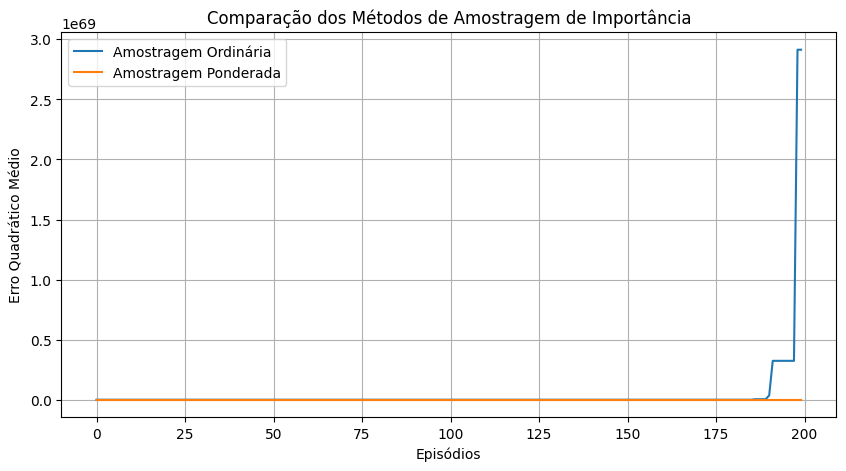

In [ ]:
# Cria o ambiente CliffWalking
env = gym.make("CliffWalking-v0")

# Instancia as políticas target e behavior
target_policy = TargetPolicy()
behavior_policy = BehaviorPolicy(nA=4)

# Executa a previsão Off-Policy com 200 episódios para o método Ordinary Importance Sampling
V_ordinary, errors_ordinary = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=200, weighted=False)

# Executa a previsão Off-Policy com 200 episódios para o método Weighted Importance Sampling
V_weighted, errors_weighted = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=200, weighted=True)

# Plota o gráfico comparativo dos erros quadráticos médios ao longo dos episódios
plot_comparison(errors_ordinary, errors_weighted)

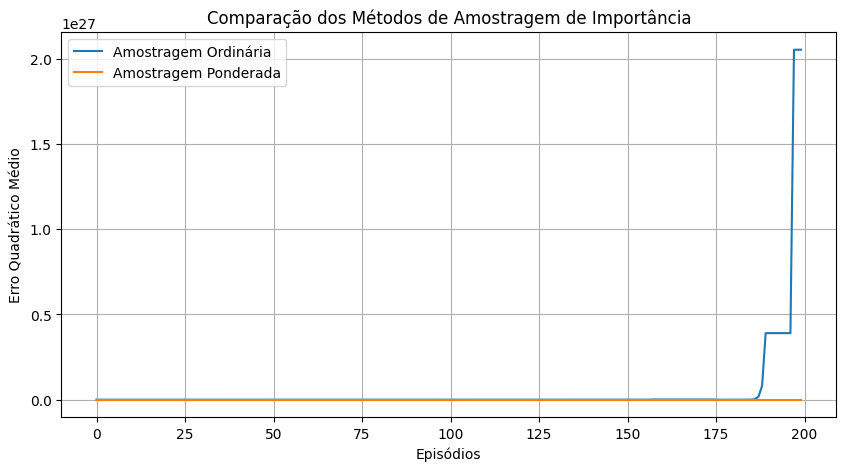

In [12]:
# Cria o ambiente CliffWalking
env = gym.make("CliffWalking-v0")

# Instancia as políticas target e behavior
target_policy = TargetPolicy2()
behavior_policy = BehaviorPolicy(nA=4)

# Executa a previsão Off-Policy com 200 episódios para o método Ordinary Importance Sampling
V_ordinary, errors_ordinary = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=200, weighted=False)

# Executa a previsão Off-Policy com 200 episódios para o método Weighted Importance Sampling
V_weighted, errors_weighted = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=200, weighted=True)

# Plota o gráfico comparativo dos erros quadráticos médios ao longo dos episódios
plot_comparison(errors_ordinary, errors_weighted)

In [27]:
def plot_comparison2(errors_ordinary, errors_weighted):
    """
    Plota a comparação dos erros quadráticos médios (MSE) ao longo dos episódios
    para os métodos de amostragem ordinária e ponderada, utilizando o RMSE (raiz do MSE)
    e escalas logarítmicas para facilitar a visualização.
    """
    # Converte as listas de erro para arrays e calcula a raiz
    rmse_ordinary = np.sqrt(np.array(errors_ordinary))
    rmse_weighted = np.sqrt(np.array(errors_weighted))
    
    plt.figure(figsize=(10, 5))
    plt.plot(rmse_ordinary, label="Amostragem Ordinária")
    plt.plot(rmse_weighted, label="Amostragem Ponderada")
    
    # Utiliza escala logarítmica para ambos os eixos
    plt.xscale("log")
    plt.yscale("log")
    
    plt.xlabel("Episódios (escala logarítmica)")
    plt.ylabel("RMSE (escala logarítmica)")
    plt.title("Comparação dos Métodos de Amostragem de Importância (RMSE)")
    plt.legend()
    plt.show()


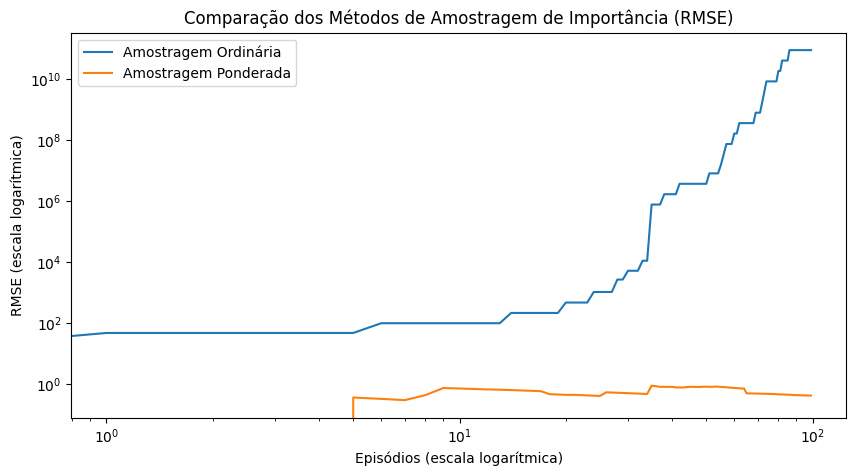

In [26]:
# Cria o ambiente CliffWalking
env = gym.make("CliffWalking-v0")

# Instancia as políticas target e behavior
target_policy = TargetPolicy2()
behavior_policy = BehaviorPolicy(nA=4)
n = 100

# Executa a previsão Off-Policy com n episódios para o método Ordinary Importance Sampling
V_ordinary, errors_ordinary = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=n, weighted=False)

# Executa a previsão Off-Policy com n episódios para o método Weighted Importance Sampling
V_weighted, errors_weighted = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=n, weighted=True)

# Plota o gráfico comparativo dos erros quadráticos médios ao longo dos episódios
plot_comparison2(errors_ordinary, errors_weighted) 